# 14회차: RNN을 활용한 영화평 감성 분석 (4) - 모델 최적화

## 고급 RNN 구현: LSTM 또는 GRU 구조 선택 IMDB 영화평 감성 분석



In [7]:
# 1. 라이브러리
import torch, numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from sklearn.utils import class_weight
import matplotlib.pyplot as plt

# 2-1. GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

Device: cuda


In [8]:
# 2-2. 주요 하이퍼패라미터 설정
vocab_size = 10000 # 사용할 단어 집합 크기 (IMDB 상위 10,000개 단어만 사용)
max_len = 500      # 입력 시퀀스 최대 길이 (부족하면 패딩, 초과하면 잘림)
batch_size = 64    # 한 번에 학습할 샘플 수 (메모리 효율과 학습 안정성에 영향)
embed_dim = 128    # 각 단어를 벡터로 변환할 때의 임베딩 차원 수
hidden_dim = 128   # RNN의 은닉 상태(hidden state) 차원 수, 문맥 요약 크기
epochs = 30        # 전체 학습 반복 횟수 (데이터셋 전체를 30번 반복 학습)
use_gru = True     # True면 GRU 사용, False면 LSTM 사용 (성능/속도 트레이드오프 있음)
num_layers = 1     # RNN 계층 수 (1이면 얕은 구조, 2 이상이면 deep RNN)

In [9]:
# 3. 데이터 로딩 및 전처리
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=vocab_size)
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)
x_train_tensor = torch.tensor(x_train, dtype=torch.long)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [10]:
# 4. 불균형 처리: class_weight → weight tensor
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
weight_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
print(weight_tensor)

tensor([1., 1.], device='cuda:0')


In [11]:
# 불균형 처리 샘플 코드
# class 0: 3개, class 1: 2개
y_train_test = [0, 0, 0, 1, 1]
class_weights_test = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train_test), y=y_train_test)
print(class_weights_test) #  ≈ [0.83, 1.25]
weight_tensor_test = torch.tensor(class_weights_test, dtype=torch.float32).to(device)
print(weight_tensor_test)

[0.83333333 1.25      ]
tensor([0.8333, 1.2500], device='cuda:0')


In [12]:
# 5. DataLoader
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [13]:
# 6. 모델 정의
class RecurrentClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, use_gru=False, dropout=0.3, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.use_gru = use_gru
        self.num_layers = num_layers
        rnn_dropout = dropout if num_layers > 1 else 0.0
        self.rnn = nn.GRU(embed_dim, hidden_dim, batch_first=True, dropout=rnn_dropout, num_layers=num_layers) if use_gru \
                   else nn.LSTM(embed_dim, hidden_dim, batch_first=True, dropout=rnn_dropout, num_layers=num_layers)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        _, h = self.rnn(x)
        hidden = h[-1] if self.use_gru else h[0][-1]
        hidden = self.dropout(hidden)
        return self.sigmoid(self.fc(hidden)).squeeze()

In [14]:
# 7. 모델/손실/옵티마이저
model = RecurrentClassifier(vocab_size, embed_dim, hidden_dim, use_gru=use_gru,
                            dropout=0.3, num_layers=num_layers).to(device)
# criterion = nn.BCELoss()  # 클래스 가중치는 아래에서 직접 적용
criterion = nn.BCELoss(reduction='none')  # 클래스 가중치는 아래에서 직접 적용
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

In [15]:
# weights를 사용해 정답 레이블 수정 계산 샘플 코드
weight_tensor_test = torch.tensor([0.8, 1.2])     # 클래스별 가중치: 0 → 0.8, 1 → 1.2
labels_test = torch.tensor([0, 1, 0, 1])          # 배치 내 레이블들
weights_test = weight_tensor_test[labels_test]    # 결과: [0.8, 1.2, 0.8, 1.2]
weights_test

tensor([0.8000, 1.2000, 0.8000, 1.2000])

In [16]:
# 8. 학습 루프
train_losses = []
print("Training started...")
for epoch in range(epochs):
    model.train()
    running_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        # 각 샘플별 클래스에 해당하는 weight 선택
        weights = weight_tensor[labels.long()]
        loss = criterion(outputs, labels)
        # 최종 손실 = 평균(샘플별 손실 × 샘플별 클래스 가중치)
        loss = (loss * weights).mean() # 클래스별 가중치 반영한 손실
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    scheduler.step()
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, LR: {scheduler.get_last_lr()[0]:.8f}")

Training started...
Epoch 1/30, Loss: 0.5738, LR: 0.00100000
Epoch 2/30, Loss: 0.3837, LR: 0.00050000
Epoch 3/30, Loss: 0.2495, LR: 0.00050000
Epoch 4/30, Loss: 0.2053, LR: 0.00025000
Epoch 5/30, Loss: 0.1646, LR: 0.00025000
Epoch 6/30, Loss: 0.1453, LR: 0.00012500
Epoch 7/30, Loss: 0.1224, LR: 0.00012500
Epoch 8/30, Loss: 0.1124, LR: 0.00006250
Epoch 9/30, Loss: 0.1020, LR: 0.00006250
Epoch 10/30, Loss: 0.0968, LR: 0.00003125
Epoch 11/30, Loss: 0.0906, LR: 0.00003125
Epoch 12/30, Loss: 0.0890, LR: 0.00001563
Epoch 13/30, Loss: 0.0856, LR: 0.00001563
Epoch 14/30, Loss: 0.0842, LR: 0.00000781
Epoch 15/30, Loss: 0.0834, LR: 0.00000781
Epoch 16/30, Loss: 0.0831, LR: 0.00000391
Epoch 17/30, Loss: 0.0821, LR: 0.00000391
Epoch 18/30, Loss: 0.0815, LR: 0.00000195
Epoch 19/30, Loss: 0.0805, LR: 0.00000195
Epoch 20/30, Loss: 0.0806, LR: 0.00000098
Epoch 21/30, Loss: 0.0815, LR: 0.00000098
Epoch 22/30, Loss: 0.0799, LR: 0.00000049
Epoch 23/30, Loss: 0.0806, LR: 0.00000049
Epoch 24/30, Loss: 0.08

In [17]:
# 9. 평가 함수
def evaluate(model, dataloader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

# 10. 평가 결과
acc = evaluate(model, test_loader)
print(f"Test Accuracy: {acc * 100:.2f}%")

Test Accuracy: 88.98%


In [18]:
%config InlineBackend.figure_format = 'retina'

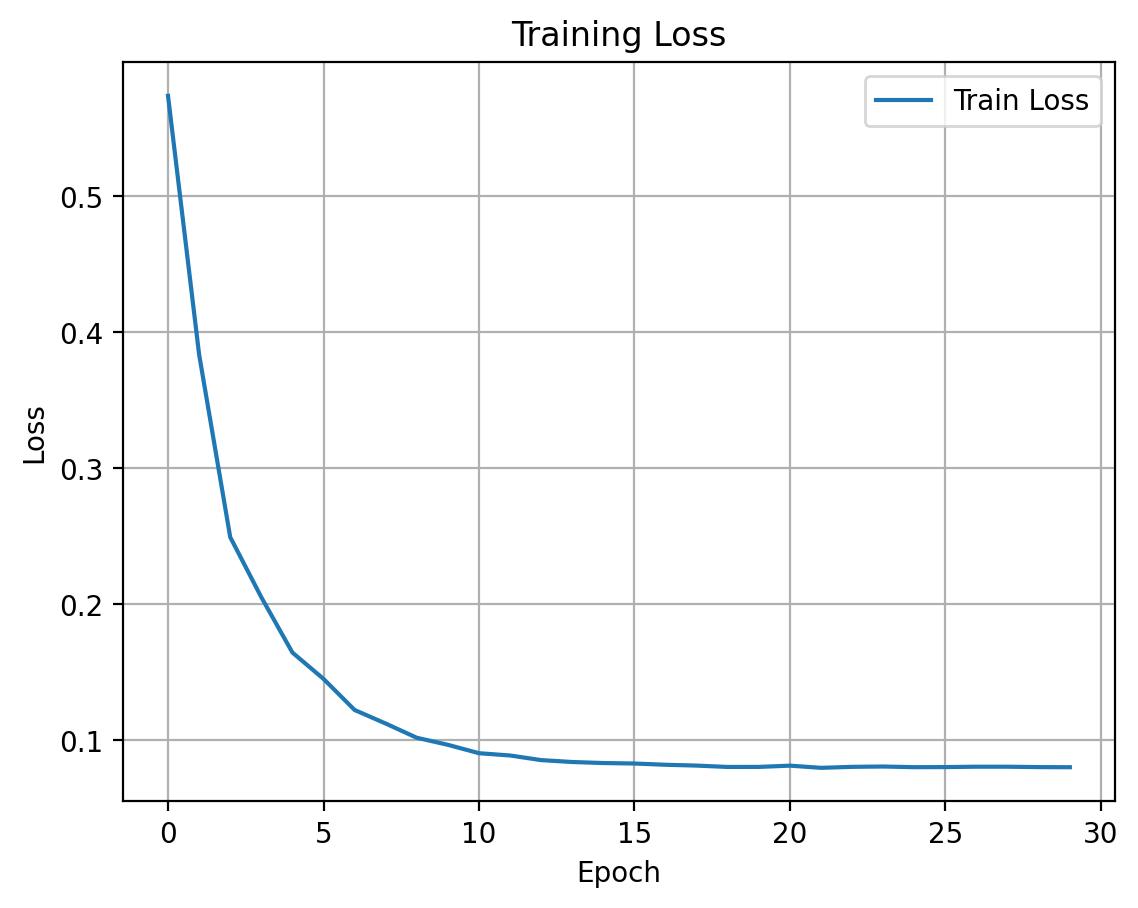

In [19]:
# 11. 손실 시각화
plt.plot(train_losses, label='Train Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid()
plt.show()

## 종료

In [22]:
from torchsummary import summary

# 모델 구조 요약 출력
# summary(모델, 입력크기) → 입력크기 형식: (sequence_length, input_size)
summary(model, input_size=(7, input_size))  # batch_size는 summary에서 자동으로 처리

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.cuda.FloatTensor instead (while checking arguments for embedding)

In [21]:
import torch
import torch.nn as nn

# 가짜 예측 확률 (시그모이드 통과 후 값) & 정답 레이블
outputs = torch.tensor([[0.9], [0.2], [0.7], [0.1]])  # 모델 출력 (4개 샘플)
labels  = torch.tensor([[1.0], [0.0], [1.0], [0.0]])  # 정답 레이블

# 1. 기본값 (reduction='mean')
criterion_mean = nn.BCELoss()  # == nn.BCELoss(reduction='mean')
loss_mean = criterion_mean(outputs, labels)

# 2. 샘플별 손실 (reduction='none')
criterion_none = nn.BCELoss(reduction='none')
loss_none = criterion_none(outputs, labels)

print("=== BCELoss 기본 (평균 손실, 스칼라) ===")
print(loss_mean)   # 하나의 숫자 (배치 전체 평균 손실)

print("\n=== BCELoss (reduction='none') ===")
print(loss_none)   # 샘플별 손실 (벡터, shape=[4,1])
print(loss_none.mean())

=== BCELoss 기본 (평균 손실, 스칼라) ===
tensor(0.1976)

=== BCELoss (reduction='none') ===
tensor([[0.1054],
        [0.2231],
        [0.3567],
        [0.1054]])
tensor(0.1976)


In [6]:
import torch
import torch.nn as nn

# 가짜 데이터 준비 (배치 크기=4)
batch_size = 4
outputs = torch.tensor([[0.9],   # 샘플1: 클래스1일 확률
                        [0.2],   # 샘플2
                        [0.7],   # 샘플3
                        [0.1]])  # 샘플4  (shape = [4,1])

labels = torch.tensor([[1.0],   # 정답 (1)
                       [0.0],   # 정답 (0)
                       [1.0],   # 정답 (1)
                       [0.0]])  # 정답 (0)  (shape = [4,1])

# 클래스별 가중치 (클래스0=0.5, 클래스1=2.0)
weight_tensor = torch.tensor([0.5, 2.0])

# 손실 함수 (샘플별 손실을 벡터로 출력)
criterion = nn.BCELoss(reduction='none')
# criterion = nn.BCELoss()
loss_per_sample = criterion(outputs, labels)

print("샘플별 손실:", loss_per_sample.squeeze())

# 레이블에 맞는 가중치 뽑기
# labels는 float이므로 long으로 변환해야 indexing 가능
weights = weight_tensor[labels.long().squeeze()]
print("샘플별 가중치:", weights)

# 클래스 가중치 반영한 최종 손실
weighted_loss = (loss_per_sample.squeeze() * weights).mean()
print("최종 가중치 적용 평균 손실:", weighted_loss.item())

샘플별 손실: tensor([0.1054, 0.2231, 0.3567, 0.1054])
샘플별 가중치: tensor([2.0000, 0.5000, 2.0000, 0.5000])
최종 가중치 적용 평균 손실: 0.27208077907562256


In [3]:
import torch

x = torch.randn(4, 1)
print("원래 shape:", x.shape)     # torch.Size([4, 1])

y = x.squeeze()
print("squeeze 후 shape:", y.shape)  # torch.Size([4])

원래 shape: torch.Size([4, 1])
squeeze 후 shape: torch.Size([4])


In [1]:
import torch
import torch.nn as nn

# 가짜 데이터 준비
batch_size = 4
num_classes = 3
outputs = torch.tensor([[2.0, 1.0, 0.1],   # 샘플1
                        [0.1, 3.0, 0.2],   # 샘플2
                        [1.0, 0.5, 2.5],   # 샘플3
                        [2.5, 0.3, 0.2]])  # 샘플4  (shape = [4,3])

labels = torch.tensor([0, 1, 2, 0])  # 정답 레이블 (shape = [4])

# 클래스별 가중치 (예: 클래스0=0.5, 클래스1=2.0, 클래스2=1.5)
weight_tensor = torch.tensor([0.5, 2.0, 1.5])

# reduction='none'으로 샘플별 손실 벡터 계산
criterion = nn.CrossEntropyLoss(reduction='none')
loss_per_sample = criterion(outputs, labels)

print("샘플별 손실:", loss_per_sample)

# 각 샘플이 속한 클래스에 맞는 weight 선택
weights = weight_tensor[labels.long()]
print("샘플별 가중치:", weights)

# 클래스 가중치 반영
weighted_loss = (loss_per_sample * weights).mean()
print("최종 가중치 적용 평균 손실:", weighted_loss.item())

샘플별 손실: tensor([0.4170, 0.1096, 0.3064, 0.1915])
샘플별 가중치: tensor([0.5000, 2.0000, 1.5000, 0.5000])
최종 가중치 적용 평균 손실: 0.2457500696182251


In [25]:
import torch
import torch.nn as nn
from torchsummary import summary

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # 입력과 같은 device로 hidden state 생성
        h0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size, device=x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# 하이퍼파라미터
input_size = 10
hidden_size = 20
num_layers = 2
num_classes = 3

# 모델 생성 (GPU가 있으면 GPU에 올림)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
md = SimpleRNN(input_size, hidden_size, num_layers, num_classes).to(device)

# 모델 구조 요약 출력
summary(md, input_size=(7, input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               RNN-1  [[-1, 7, 20], [-1, 2, 20]]               0
            Linear-2                    [-1, 3]              63
Total params: 63
Trainable params: 63
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.00
Estimated Total Size (MB): 0.04
----------------------------------------------------------------
